In [4]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling: #=True
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else: #upsample
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x): #passes the input tensor x through the convolutional operations defined in the ConvolutionalBlock
        return self.conv(x)


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):

        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        This skip connection, used to address vanishing gradient issue
        """
        return x + self.block(x)


In [6]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):
        """
        Architecture:

        Initial layer: convolutional layer
        2 downsampling layers for encoding
        num_residual number of residual blocks-> each block 2 conv layers then residual connection
        2 upsampling layers
        Last layer: Convolutional layer with tanh for normalization [-1,1]
        """

        """
        The architecture follows an encoder-decoder structure with residual connections.
        Downsampling and upsampling layers help in feature extraction and reconstruction, respectively.
        Residual blocks aid in learning residual mappings, allowing for more efficient training and better preservation of image details.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect", #preserve spatial dimensions
            ),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        """
        def __init__(self, channels: int):

        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

        num_resisduals = number of residual blocks
        num_features * 4 = input and output channels 
        """

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))  #output pixel values in range [-1,1]


In [7]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Architecture: 
        Conv layer
        Instance normalization -> stabilize learing process and fastens convergence
        Leaky relu -> nonlinearity
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512.

        After the last layer, we apply a convolution to produce a 1-dimensional
        output.

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(  
                    in_channels,   
                    feature,
                    stride=1 if feature == features[-1] else 2, #s=1->downsampling
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output
        
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        # 64->128, 128->256,256->512, 512->1
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [9]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class CelebMonetDataset(Dataset):
    def __init__(self, root_monet, root_celeb, transform=None):
        self.root_monet = root_monet
        self.root_celeb = root_celeb
        self.transform = transform

        self.monet_images = os.listdir(root_monet)
        self.celeb_images = os.listdir(root_celeb)
        self.length_dataset = max(len(self.monet_images), len(self.celeb_images))  #sample both types of images equally
        self.monet_len = len(self.monet_images)
        self.celeb_len = len(self.celeb_images)

    def __len__(self):
        return self.length_dataset

    # retrieves a pair of images corresponding to a given index.
    def __getitem__(self, index):
        monet_img = self.monet_images[index % self.monet_len]
        celeb_img = self.celeb_images[index % self.celeb_len]

        monet_path = os.path.join(self.root_monet, monet_img)
        celeb_path = os.path.join(self.root_celeb, celeb_img)

        monet_img = np.array(Image.open(monet_path).convert("RGB"))
        celeb_img = np.array(Image.open(celeb_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=monet_img, image0=celeb_img)
            monet_img = augmentations["image"]
            celeb_img = augmentations["image0"]

        return monet_img, celeb_img


In [10]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
#LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
#NUM_WORKERS = 0
NUM_EPOCHS = 2
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GENERATOR_C = r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\models\genh.pth.tar"  #generator for celebrity
CHECKPOINT_GENERATOR_M = r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\models\genz.pth.tar" #generator for monet style
CHECKPOINT_DISCRIMINATOR_C = r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\models\disch.pth.tar" #discriminator for celebrity
CHECKPOINT_DISCRIMINATOR_M = r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\models\discz.pth.tar" #discriminator for monet

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    is_check_shapes=False,
    additional_targets={"image0": "image"},
)

using device: cuda


In [11]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="C:\\Users\\cl502_10\\Desktop\\GANS\\celeb2monet\\models\\checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(
    disc_C, disc_M, gen_M, gen_C, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    C_reals = 0
    C_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (monet, celeb) in enumerate(loop):
        monet = monet.to(DEVICE)
        celeb = celeb.to(DEVICE)

        # Train discriminators C and M
        with torch.cuda.amp.autocast():
            fake_celeb = gen_C(monet)
            D_C_real = disc_C(celeb)
            D_C_fake = disc_C(fake_celeb.detach())
            C_reals += D_C_real.mean().item()
            C_fakes += D_C_fake.mean().item()
            D_C_real_loss = mse(D_C_real, torch.ones_like(D_C_real))
            D_C_fake_loss = mse(D_C_fake, torch.zeros_like(D_C_fake))
            D_C_loss = D_C_real_loss + D_C_fake_loss

            fake_monet = gen_M(celeb)
            D_M_real = disc_M(monet)
            D_M_fake = disc_M(fake_monet.detach())
            D_M_real_loss = mse(D_M_real, torch.ones_like(D_M_real))
            D_M_fake_loss = mse(D_M_fake, torch.zeros_like(D_M_fake))
            D_M_loss = D_M_real_loss + D_M_fake_loss

            D_loss = (D_C_loss + D_M_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators C and M
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_C_fake = disc_C(fake_celeb)
            D_M_fake = disc_M(fake_monet)
            loss_G_C = mse(D_C_fake, torch.ones_like(D_C_fake))
            loss_G_M = mse(D_M_fake, torch.ones_like(D_M_fake))

            # cycle losses
            cycle_monet = gen_M(fake_celeb)
            cycle_celeb = gen_C(fake_monet)
            cycle_monet_loss = l1(monet, cycle_monet)
            cycle_celeb_loss = l1(celeb, cycle_celeb)

            # total loss
            G_loss = (
                loss_G_M
                + loss_G_C
                + cycle_monet_loss * LAMBDA_CYCLE
                + cycle_celeb_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_celeb * 0.5 + 0.5, f"C:\\Users\\cl502_10\\Desktop\\GANS\\celeb2monet\\outputs\\celeb_{idx}.png")
            save_image(fake_monet * 0.5 + 0.5, f"C:\\Users\\cl502_10\\Desktop\\GANS\\celeb2monet\\outputs\\monet_{idx}.png")

        loop.set_postfix(H_real=C_reals / (idx + 1), H_fake=C_fakes / (idx + 1))


In [13]:
def main():
    disc_C = Discriminator(in_channels=3).to(DEVICE)
    disc_M = Discriminator(in_channels=3).to(DEVICE)
    gen_C = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_C = Generator(img_channels=3, num_residuals=9).to(DEVICE)

    # use Adam Optimizer for both generator and discriminator
    opt_disc = optim.Adam(
        list(disc_C.parameters()) + list(disc_M.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_C.parameters()) + list(gen_C.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GENERATOR_C,
            gen_C,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GENERATOR_M,
            gen_C,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISCRIMINATOR_C,
            disc_C,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISCRIMINATOR_M,
            disc_M,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = CelebMonetDataset(
        root_celeb=r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\trainA",
        root_monet=r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\trainB",
        transform=transforms,
    )
    val_dataset = CelebMonetDataset(
        root_celeb=r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\testA",
        root_monet=r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\testB",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_C,
            disc_M,
            gen_C,
            gen_C,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_C, opt_gen, filename=CHECKPOINT_GENERATOR_C)
            save_checkpoint(gen_C, opt_gen, filename=CHECKPOINT_GENERATOR_M)
            save_checkpoint(disc_C, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_C)
            save_checkpoint(disc_M, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_M)
main()

C:\Users\cl502_10\AppData\Roaming\Python\Python39\site-packages\torch\_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)
100%|█████████████████████████████████████████████████████| 829/829 [02:30<00:00,  5.50it/s, H_fake=0.43, H_real=0.566]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████████████| 829/829 [02:25<00:00,  5.71it/s, H_fake=0.41, H_real=0.591]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


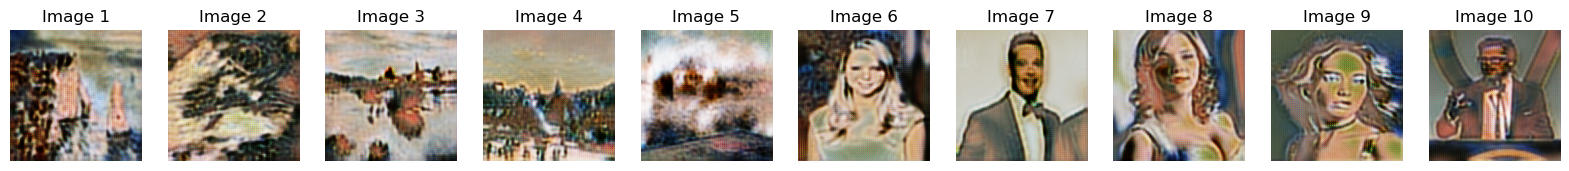

In [14]:
import matplotlib.pyplot as plt
import cv2

# Define the path to the folder containing the images
folder_path = r"C:\Users\cl502_10\Desktop\GANS\celeb2monet\outputs"

# Get the list of all files in the folder
image_files = os.listdir(folder_path)

# Sort the files to ensure consistent order
image_files.sort()

# Create a figure and axis for plotting
fig, axes = plt.subplots(1, len(image_files), figsize=(20, 5))

# Loop through each image file and plot it
for i, image_file in enumerate(image_files):
    # Read the image using OpenCV
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB (Matplotlib expects RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

# Show the plot
plt.show()